**Pulse Data Exploration Task**

**The exercise is to develop an algorithm to identify locations a person frequently spends time at and evaluate your approach to classify these location into categories.**

**Brief Background: how is the data collected?**
Pulse iD integrates and SDK inside a client’s mobile app which provides the app-users location even when the app is closed. One of the core technologies used is geofencing, where we get a signal from an app user when he/she enters and exits a certain area. Besides that, we obtain a app users location if he moves more than a specified distance since the last location we have on file and when a specified time has past since the last interaction with this user.

What is provided:
1. Data File (CSV)
2. Data Dictionary (XLSX)
3. Jupyter Notebook for output (http://jupyter.org/)

**Functional requirements:**
1. Algorithm to identify frequently visited places
    * Using Jupyter, explain and explore features in the data, along with the frequently visited locations
        * Use appropriate visuals for explanation (map-plots, graphs,... ) 
        * When hard coding values, explain why that specific value is chosen
        * Output would be an Algorithm that identifies frequently visited places [1]
    * Document what data seems to contain errors and show how you deal with this erroneous data
2. Classification frequently visited places
    * Document your proposed approach to classify the locations found by [1] into ‘home’ and ‘other’ (max. 2 pages)

**Nice to have functional requirements:**
* Using Jupyter, prototype the approach outlined in [2] in a Jupyter notebook

**Non-functional requirements:**
* Choose any libraries you want for investigating this task
* Write clean & understandable code
    * Add additional comments as necessary to explain your approach
* Create reproducible results

**Nice to have non-functional requirements:**
* Identify and explain what additional data could improve the value of the current dataset
* Show research steps (i.e. plots) leading to the final output
* All aspects not specified above are open for your own interpretation


Good luck!




# Further Exploratory Data Analysis - Temporal Statistics of the User Data

In this notebook I explore the temporal statistics of the user data more rigorously. I attempt to model the data as a Poisson point process and to fit Hidden Markov Models to it in order to determine possible underlying or hidden generating states.

##  Point Process Modeling of User Data

A [point process](https://en.wikipedia.org/wiki/Point_process)  is a collection of mathematical points randomly distributed on a plane or a line. A line could represent a spatial dimension or, more commonly, time. The reception of locations from a user is a spatio-temporal point process. However, when ignoring spatial location and considering only temporal information,  a line point process is a  good model for the reception of location information.  The hope is that the temporal statistics exhibit certain patterns that enable us to distinguish different kinds of locations from each other. We might expect different location return statistics when a user is at home, at work or on holiday. Many other factors will come into play and disentangling them will not be trivial but certainly we should be able to glean some useful information from the data with such an analysis.

## Poisson Point Process and Distribution

When considering the points that occured within a time interval as a [Poisson point process](https://en.wikipedia.org/wiki/Poisson_point_process), the distribution of the number of points within that time interval is described by the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), defined by:

\begin{equation}
P \{ N(t)=n \} = \frac{(\lambda t)^n}{ n!} \exp{(-\lambda t)}
\end{equation}

This expression gives the probabiliy of $N=n$ counts in a time interval $t$, where   $\lambda t$ is the mean number of counts for the time interval. 

## Hidden Markov Models

[Hidden Markov models](https://en.wikipedia.org/wiki/Hidden_Markov_model) are statistical models of signals that can be Gaussian or Poisson distributed observations but are generated by an underlying (or hidden) Markov process, in conjunction with a Gaussian or a Poisson emission probability distribution. The observations can be correlated in complicated manners but the hidden Markov process obeys the Markov property of being independent of all but the last state. For many problems the hidden states have a physical meaning that gives insight into the generating mechanism of the signal and can also be used to classify it [4,5].

## Temporal Statistics of User Location Data

If we consider only the temporal information from a spatial cluster we have a point process. It is interesting to study the statistics of such point processes to see if we can glean information from them that helps undertand and predict user behaviour.

### Plan of Action

Revisiting the three service users studied in the previous notebook, I will first convert all location data for each into a point process (regardless of the spatial location). I will examine some statistics of the time intervals between the reception of location information using Q-Q plots to see how well such data fits the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) that time intervals from Poisson point processes should follow. Finally I will fit Poisson Markov Models to count data derived from the time interval data and see if I can  correlate the hidden states thus found to the behaviour of each user. The hope is that ultimately some information about the location of the user can be obtained from his temporal statistics.

### Importing libraries

In [420]:
#Pre-loaded functions
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from mpl_toolkits.basemap import Basemap

##  General Locations

I load the dataset into a pandas dataframe.

In [421]:
df=pd.read_csv('ds_task_extract.csv',encoding='latin-1')


C:\Users\jamil\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (25,26,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I create a new dataframe with the columns I believe that are essential for accurate localization and identification.

In [422]:
data = df[['latitude', 'longitude', 'location_accuracy','timestamp', 'tag2_value', 'session']]
np.shape(data)

(380546, 6)

In [423]:
data.head()

,latitude,longitude,location_accuracy,timestamp,tag2_value,session
0,NaN,NaN,0,1476325178,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
1,NaN,NaN,0,1476325184,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2,-6.926895,107.63402,2000,1476325184,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
3,-6.926904,107.63403,2000,1476325697,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
4,NaN,NaN,0,1476337923,Asia/Jakarta,20FF79D7396046F6AFA1786B2DB3F545


The timestamps need to be converted to a form immediately legible to humans and set as the index of the dataframe.

In [424]:
data.index = data['timestamp']

data = data.drop('timestamp', 1)
data.columns = ['lat', 'long', 'error','time_zone', 'ID']
data.index = pd.to_datetime(data.index.values, unit='s', utc= True)
data.head()

,lat,long,error,time_zone,ID
2016-10-13 02:19:38+00:00,NaN,NaN,0,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:19:44+00:00,NaN,NaN,0,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:19:44+00:00,-6.926895,107.63402,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:28:17+00:00,-6.926904,107.63403,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 05:52:03+00:00,NaN,NaN,0,Asia/Jakarta,20FF79D7396046F6AFA1786B2DB3F545


Rows (or equivalently, times) not containing location information are removed.

In [425]:
data = data.dropna()
data.head()

,lat,long,error,time_zone,ID
2016-10-13 02:19:44+00:00,-6.926895,107.63402,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:28:17+00:00,-6.926904,107.63403,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 05:52:08+00:00,-2.940363,104.73718,165,Asia/Jakarta,20FF79D7396046F6AFA1786B2DB3F545
2016-10-13 06:50:41+00:00,-5.844771,112.65810,65,Asia/Jakarta,E682062F8A344B1FBE591AFEE5D1084A
2016-10-13 07:42:32+00:00,-5.849558,112.65785,65,Asia/Jakarta,E682062F8A344B1FBE591AFEE5D1084A


## Case Studies of Three Service Users

The ID column labels location data from different service users or individuals. In order to understand location patterns better I will investigate the data from the three most active service users in detail. 

In [426]:
data['ID'].value_counts() # value_counts() counts unique occurences

7935F740476346B6BD36672576F001D5    897
283FCF1B13BC4D9C947AD983621D1EB1    885
020617FA36714A919789E2CEDF062BB6    792
693F438096B34926B05C76EC75366AD6    651
2F9D08E972934BAAA3702A67B605AA29    647
464865F5521D4D7B9D09D7B0F3052FC4    616
6B3837764A6E446A89A24CA18BCE882A    607
14E2BF3252CB4B4282C1F4B556AAC4E4    577
7C6405D36BAA4EA2A601A0F4462DBE71    525
F5439A2F97B6419D83569E21455DC020    497
E40C6352EDCA467EAD23F4873BAB6CB4    494
533F0016115A45C788E6E73AA829CE80    494
80A500967E2C445FBFD726851B022984    472
7F201A349BEA449F998A1D8115C342C4    463
5F39E81A63B346D5ADC4C830BF536D0A    457
2622ADFA67664E7FA12F914AD0909BE8    457
AD1427C4555A4BE1B33AC56ACA24DFF8    450
FA76F0D6FE1A4349BD2EA94B6B7AB366    446
E836DB1374AA4B53B745BD951D0C8476    405
5F5218121AD84DF8BAD8E2FAAD767ED3    396
7DAF1F766424490CAF1C1329F25CD954    390
9E462EFCCD8045D39AC966E26BF800AB    374
98E8059807624C39866B466AD5E4F938    371
2B72A3353C2D48D68624262B62A228D4    370
D09E1C8C8789470BA2660448E1088E82    363


The dataset consists of location data from 1385 users. I proceed to  explore the data from the top three users in detail. 

## Profile of User One

### The General Locations of User One

Now I examine the general locations dataset for user one.

In [427]:
ID1 = data[ data['ID'] == '7935F740476346B6BD36672576F001D5']

In [428]:
ID1.head()

,lat,long,error,time_zone,ID
2016-12-02 06:49:44+00:00,1.490873,124.86219,165,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 02:14:33+00:00,1.488766,124.84024,249,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 03:02:20+00:00,1.491944,124.84509,165,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 07:50:51+00:00,1.493723,124.86465,149,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 09:54:47+00:00,1.490844,124.84582,65,Asia/Makassar,7935F740476346B6BD36672576F001D5


In [429]:
ID1.describe()

,lat,long,error
count,897.000000,897.000000,897.000000
mean,-5.365654,108.564082,133.325530
std,2.355842,6.618575,384.848595
min,-6.197942,0.000000,0.000000
25%,-6.176940,106.790320,65.000000
50%,-6.176536,106.790560,87.000000
75%,-6.176095,106.791046,165.000000
max,1.540755,124.920690,10678.000000


In [430]:
ID1[ID1['error'] < 300].count()

lat          883
long         883
error        883
time_zone    883
ID           883
dtype: int64

In [431]:
ID1 = ID1[ID1['error'] < 300]
ID1.describe()

,lat,long,error
count,883.000000,883.000000,883.000000
mean,-5.405109,108.469192,104.884485
std,2.304327,6.531068,51.656793
min,-6.197942,0.000000,0.000000
25%,-6.176944,106.790320,65.000000
50%,-6.176549,106.790560,86.000000
75%,-6.176139,106.791018,165.000000
max,1.494193,124.869250,278.000000


I can now drop the ID column from user one's dataframe to make it more compact.

In [432]:
ID1 = ID1.drop('ID', 1)

In [433]:
latone = ID1['lat'].values
longone = ID1['long'].values
errorone = ID1['error'].values
np.shape(errorone)

(883,)

In order to see where user one is situated I plot his locations on a map.

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 0.0 124.86925
latitude range -6.197942 1.494193
size of data (883,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


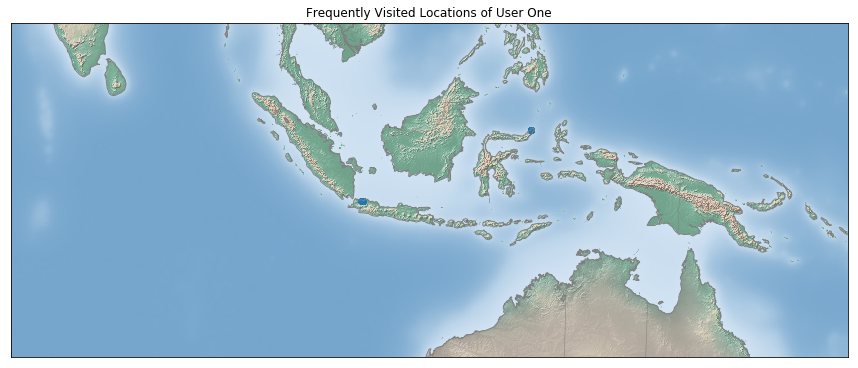

In [434]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('Frequently Visited Locations of User One')

print('longitude range', np.min(longone), np.max(longone))
print('latitude range', np.min(latone), np.max(latone))
print('size of data', np.shape(longone))
map.scatter(longone, latone, latlon=True)

This user spends his time at two locations quite far from each other. Let's plot the latitude and longitude of this user's locations against time to track his movements.

Text(0.5,1,'Time Evolution of Location Coordinates of User One')

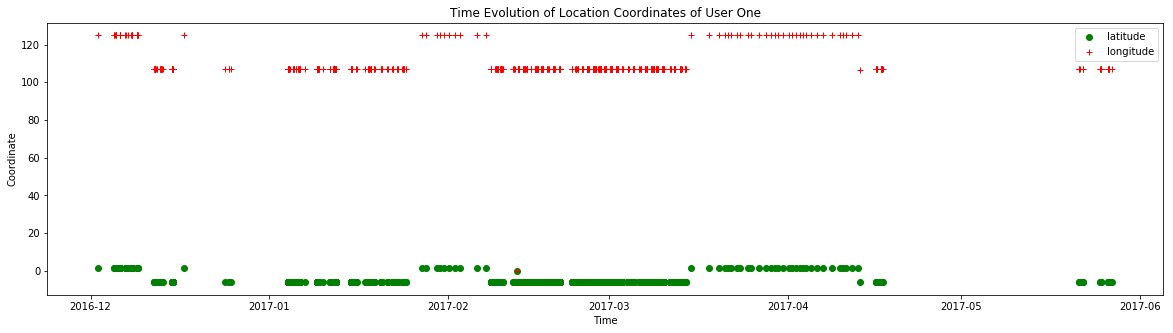

In [435]:
fig = plt.figure(figsize=[20,5])
plt.plot (ID1.index, latone, 'go', label ='latitude')
plt.plot (ID1.index, longone, 'r+', label = 'longitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Location Coordinates of User One')

I plot the locations now with the errors associated with each point represented by the area of a circle, i.e. the larger the area the larger the uncertainty.

Text(0,0.5,'latitude')

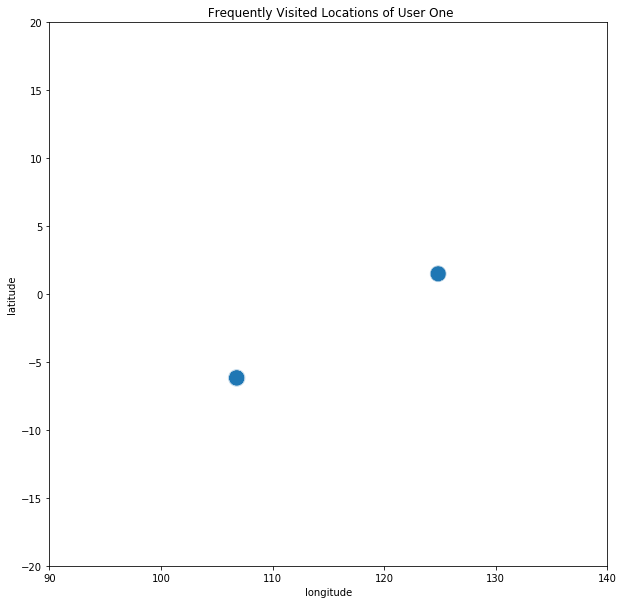

In [436]:
fig = plt.figure(figsize=(10,10))
plt.scatter(longone, latone, s= errorone, alpha = 0.2)
plt.ylim(-20,20)
plt.xlim(90,140)
plt.title(' Frequently Visited Locations of User One')
plt.xlabel('longitude')
plt.ylabel('latitude')

Checking these coordinates on google maps the western location corresponds to Jakarta, Indonesia's capital and largest city, while the eastern location is the small city of Manado in North Sulawesi province. User one shifts between both places. He spends extended lengths of time at both places but more of his time is spent in Jakarta.

In [437]:
# converting the lat, long and error columns of the dataframe to a numpy matrix

ID1sorted = ID1
coordinates = ID1sorted.as_matrix(columns=[ 'long', 'lat', 'error'])

## Temporal Distribution for User One

I convert the location data into a point process, with a one for all times at which a location was received from the user. I then display a receive pattern verus time graph.

Text(0.5,1,'Times of Reception of Location from User One')

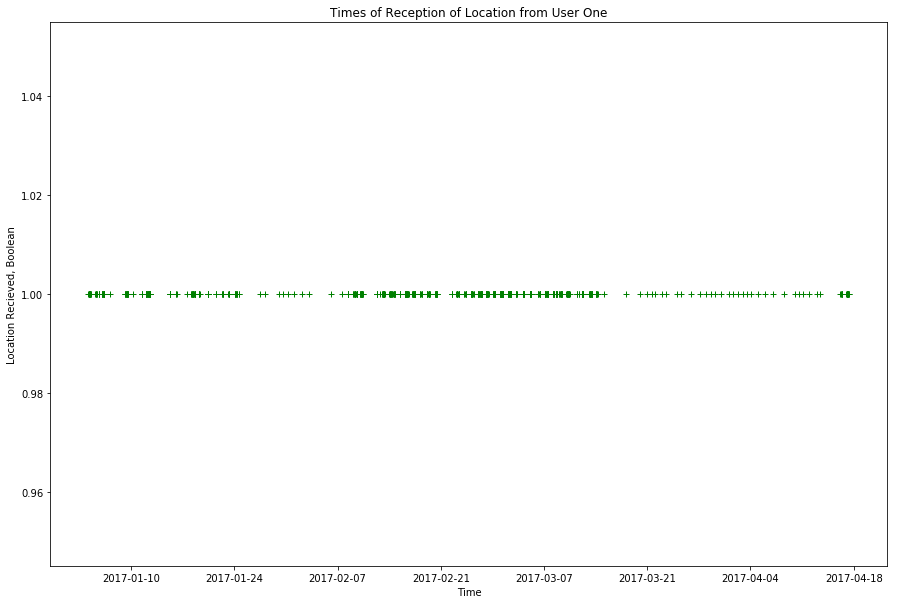

In [438]:
plt.figure(figsize=(15,10))
pointdf = (ID1sorted['long'] != 0)

pointdf = pointdf.loc['2017-1':'2017-4']
pointdf = pointdf[pointdf.values != 0]

# times not one will be NANs - convert to zero
#pointdf = pointdf.fillna(0)

plt.plot(pointdf.index, pointdf, 'g+')

np.shape(pointdf)
pointdf.head()
plt.xlabel('Time')
plt.ylabel('Location Recieved, Boolean')
plt.title('Times of Reception of Location from User One')

I want to see how the time intervals between location receive varys with time. I compute the time intervals by forming a new dataframe and taking the difference with a shifted version of itself.

In [439]:
delta = pd.DataFrame()
delta['tvalue'] = pointdf.index
delta.head()

,tvalue
0,2017-01-04 05:13:49+00:00
1,2017-01-04 05:28:53+00:00
2,2017-01-04 05:37:55+00:00
3,2017-01-04 05:46:34+00:00
4,2017-01-04 06:09:12+00:00


In [440]:
delta['tvalue'] = delta['tvalue'] - delta['tvalue'].shift()
delta.head(10)

,tvalue
0,NaT
1,00:15:04
2,00:09:02
3,00:08:39
4,00:22:38
5,00:04:17
6,00:18:32
7,00:27:33
8,00:25:52
9,00:45:05


Text(0.5,1,'Time Interval between Locations Recieved against Time for User One')

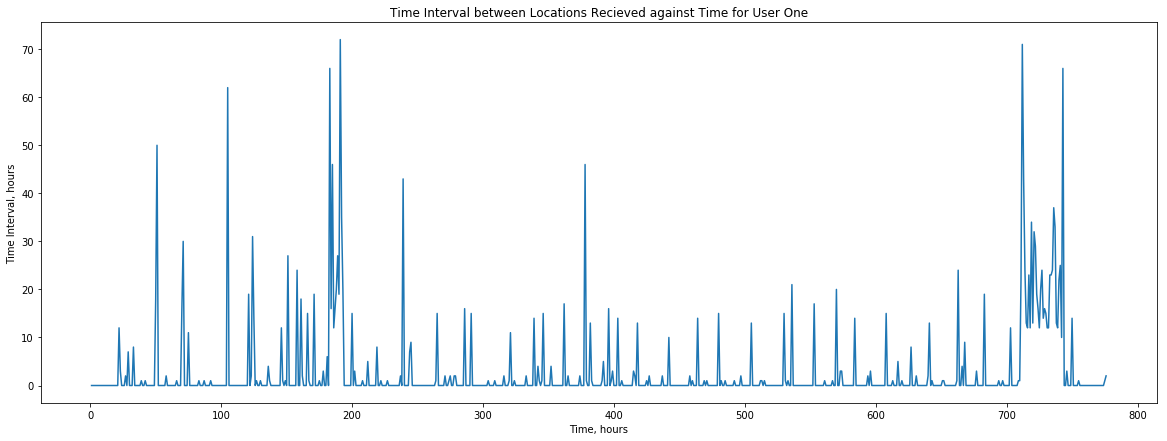

In [441]:
fig = plt.figure(figsize=(20,7))
np.shape(delta)

delarray = delta['tvalue'].astype('timedelta64[s]') # seconds for a fine Q-Q plot
delarrayplot = delta['tvalue'].astype('timedelta64[h]') # hourly for convenient display
delarray = delarray.dropna()
delarrayplot = delarrayplot.dropna()


plt.plot(delarrayplot)
plt.xlabel('Time, hours')
plt.ylabel('Time Interval, hours')
plt.title('Time Interval between Locations Recieved against Time for User One')

In [442]:
delarray.head()

1     904.0
2     542.0
3     519.0
4    1358.0
5     257.0
Name: tvalue, dtype: float64

Text(0.5,1,'Distribution of Times between Location Recieves for User One')

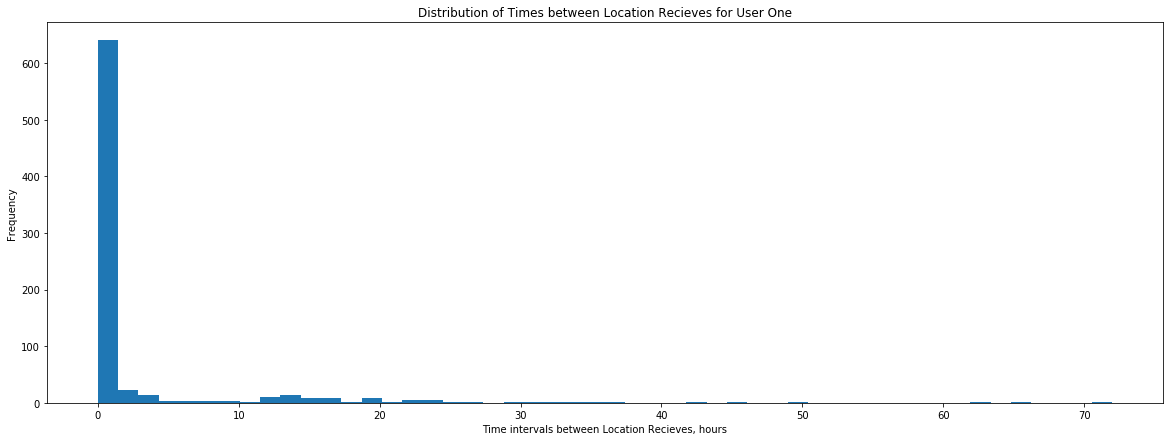

In [443]:
fig = plt.figure(figsize=(20,7))
delarrayplot.plot.hist(bins=50)
plt.xlabel('Time intervals between Location Recieves, hours')
plt.title('Distribution of Times between Location Recieves for User One')

In a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) the quantiles of  sample data are plotted against the quantiles of a selected distribution. If the samples are in indeed from the selected distribution then a straight line is obtained. Any deviation from a straight line is an indication of a deviation of the sample distribution from the proposed distribution. I plot the time intervals of the sample point process againt quantiles of an exponential distribution. For an ideal Poisson point process the time intervals should be [exponential distributed](https://en.wikipedia.org/wiki/Exponential_distribution).

Text(0.5,1,'Exponential Q-Q Plot')

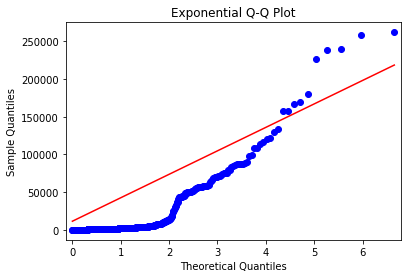

In [444]:
import statsmodels.api as sm
import scipy.stats as stats

fig = sm.qqplot(delarray, stats.expon, line='s') # For improved accuracy I use seconds data here not hourly
plt.title('Exponential Q-Q Plot')

This Q-Q plot seems to consists of two straight lines at different angels. This suggests the data is drawn from two exponential distributions, which corresponds to two point processes with different lambdas. 

From the point process I form a counting dataset. This counting data should be Poisson distributed (with data generated from two different lambdas according to the above discussion). To reduce the noise I had to aggregate sums over 3 days. The data in this form can have a Poisson Markov model fit to it to find hidden states.

Text(0.5,1,'Counts of Locations Received per 3 Days Against Time, for User One')

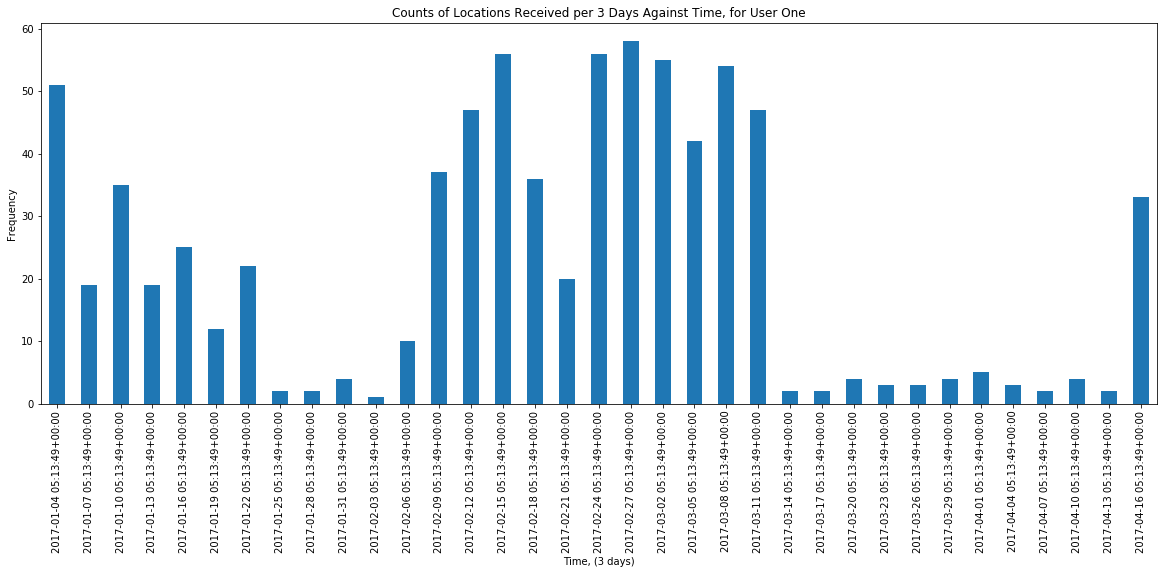

In [445]:
plt.figure(figsize=(20,7))

countdf = pointdf.groupby(pd.TimeGrouper(freq='3D')).agg('sum')

countdf.plot(kind='bar')
plt.xlabel('Time, (3 days)')
plt.ylabel('Frequency')
plt.title('Counts of Locations Received per 3 Days Against Time, for User One')

In [446]:
countdf = countdf.fillna(0)
countdf.head()

2017-01-04 05:13:49+00:00    51.0
2017-01-07 05:13:49+00:00    19.0
2017-01-10 05:13:49+00:00    35.0
2017-01-13 05:13:49+00:00    19.0
2017-01-16 05:13:49+00:00    25.0
Freq: 3D, Name: long, dtype: float64

I now fit a Poisson Markov model to the data using the [sklearn-bayes](https://github.com/AmazaspShumik/sklearn-bayes) module.

In [447]:
from skbayes.hidden_markov_models import VBPoissonHMM

count = countdf.values
count = count.reshape(-1, 1)

## on the basis of the above Q-Q plot I look for TWO hidden states
model = VBPoissonHMM(n_hidden=2, n_init = 2, tol = 1e-3).fit(count)
hidden_states = model.predict(count)

#plt.figure(figsize=(20,7))
#plt.plot(hidden_states)
#plt.xlabel('Time')
#plt.ylabel('State')
#plt.title('States Found by Poisson Hidden Markov Model versus Time for User One')

The aggregation over 3 days has reduced the size of the dataset. In order to facilitate comparison with the orignal datset for user one I upsample the numpy array containing the hidden state data and plot it. The upsampling is done by replacing each point in the array with three points containing the same value for the hidden state. (A kronecker product is used to achieve this)

In [448]:
hidden_states = hidden_states[:, None]
np.shape(hidden_states)

(35, 1)

In [449]:
hiddenup = np.kron(hidden_states, np.ones((3,1), hidden_states.dtype))
np.shape(hiddenup)
np.squeeze(hiddenup)
np.shape(hiddenup)

(105, 1)

Text(0.5,1,'States Found by Poisson Hidden Markov Model versus Time for User One')

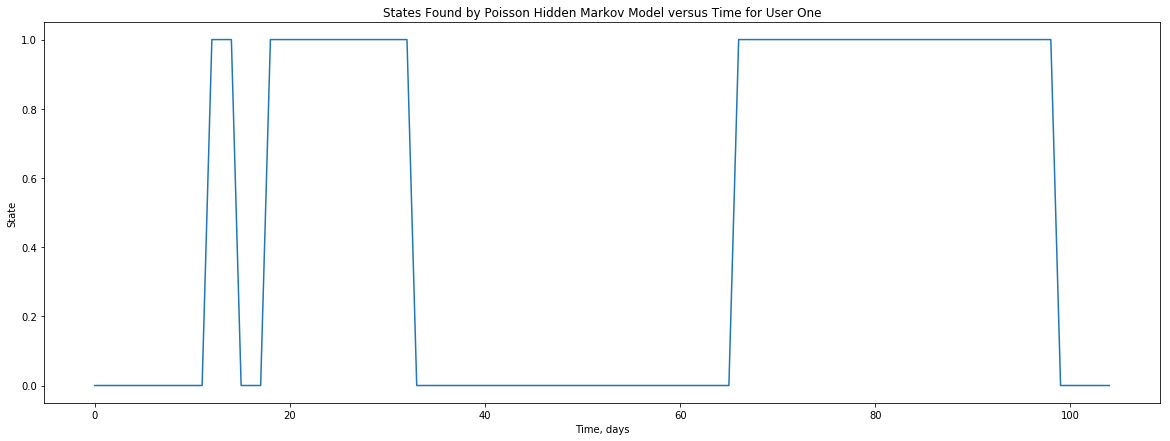

In [450]:
plt.figure(figsize=(20,7))

plt.plot(hiddenup)
plt.xlabel('Time, days')
plt.ylabel('State')
plt.title('States Found by Poisson Hidden Markov Model versus Time for User One')


### Discussion on User One

## Profile of User Two

I repeat the above analysis for user two.

In [451]:
ID2 = data[data['ID'] == '020617FA36714A919789E2CEDF062BB6']
ID2.head()

,lat,long,error,time_zone,ID
2016-12-30 11:25:10+00:00,1.122040,104.02480,1414,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-30 15:03:35+00:00,1.125491,104.02973,10,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-30 23:51:52+00:00,1.121591,104.02548,1414,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-31 11:43:28+00:00,1.128759,104.03133,10,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-31 11:57:59+00:00,1.128759,104.03133,10,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6


In [452]:
ID2 = ID2.drop('ID', 1)
ID2.head()

,lat,long,error,time_zone
2016-12-30 11:25:10+00:00,1.122040,104.02480,1414,Asia/Jakarta
2016-12-30 15:03:35+00:00,1.125491,104.02973,10,Asia/Jakarta
2016-12-30 23:51:52+00:00,1.121591,104.02548,1414,Asia/Jakarta
2016-12-31 11:43:28+00:00,1.128759,104.03133,10,Asia/Jakarta
2016-12-31 11:57:59+00:00,1.128759,104.03133,10,Asia/Jakarta


In [453]:
ID2.describe()

,lat,long,error
count,792.000000,792.000000,792.000000
mean,1.127744,104.028999,118.405303
std,0.009882,0.009625,206.103993
min,1.041687,103.936910,5.000000
25%,1.125324,104.028404,65.000000
50%,1.127978,104.031128,65.000000
75%,1.128750,104.031720,165.000000
max,1.158209,104.056830,1414.000000


In [454]:
lat2 = ID2['lat'].values
long2 = ID2['long'].values
error2 = ID2['error'].values
np.shape(lat2)

(792,)

Text(0.5,1,'Time Evolution of Location Coordinates of User Two')

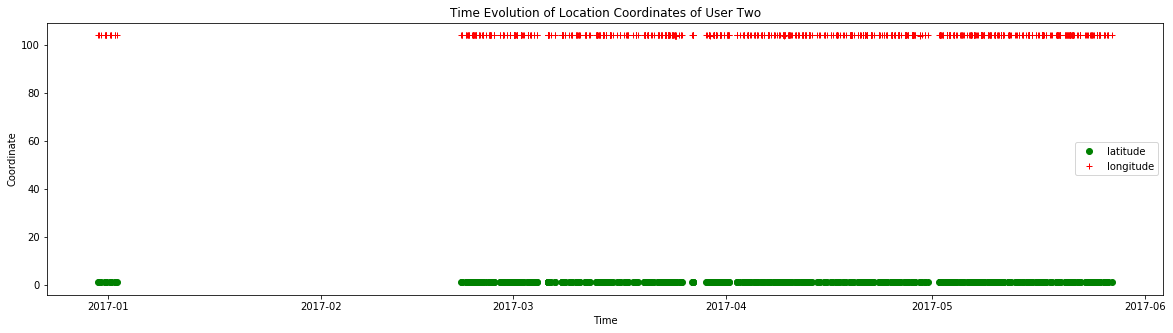

In [455]:
fig = plt.figure(figsize=[20,5])
plt.plot(ID2.index, lat2, 'go', label= 'latitude')
plt.plot (ID2.index, long2, 'r+', label = 'longitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Location Coordinates of User Two')

There is a large gap in user two's activity between January 2017 and mid February 2017. User two lived in the island Batam and seems to spend all his time there.

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 103.93691 104.05683
latitude range 1.041687 1.158209
size of data (792,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


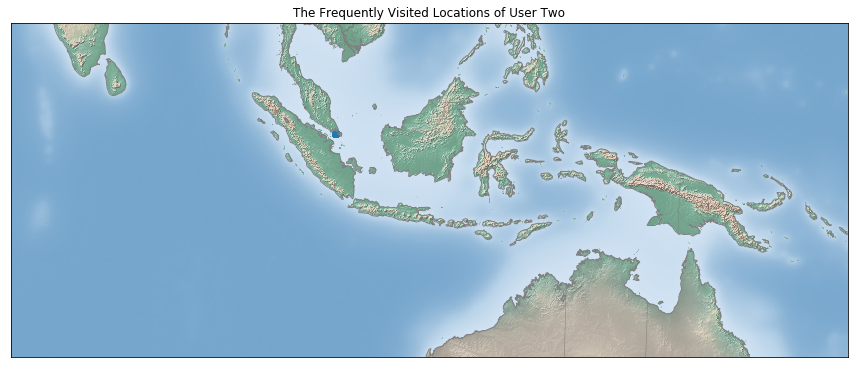

In [456]:
fig = plt.figure(figsize=(15, 15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('The Frequently Visited Locations of User Two')

print('longitude range', np.min(long2), np.max(long2))
print('latitude range', np.min(lat2), np.max(lat2))
print('size of data', np.shape(long2))
map.scatter(long2, lat2, latlon=True)

In [457]:
np.shape(ID2)

(792, 4)

In [458]:
ID2.head()

,lat,long,error,time_zone
2016-12-30 11:25:10+00:00,1.122040,104.02480,1414,Asia/Jakarta
2016-12-30 15:03:35+00:00,1.125491,104.02973,10,Asia/Jakarta
2016-12-30 23:51:52+00:00,1.121591,104.02548,1414,Asia/Jakarta
2016-12-31 11:43:28+00:00,1.128759,104.03133,10,Asia/Jakarta
2016-12-31 11:57:59+00:00,1.128759,104.03133,10,Asia/Jakarta


In [459]:
ID2.describe()

,lat,long,error
count,792.000000,792.000000,792.000000
mean,1.127744,104.028999,118.405303
std,0.009882,0.009625,206.103993
min,1.041687,103.936910,5.000000
25%,1.125324,104.028404,65.000000
50%,1.127978,104.031128,65.000000
75%,1.128750,104.031720,165.000000
max,1.158209,104.056830,1414.000000


I remove all data with location errors greater than 300m.

In [460]:
ID2[ID2['error'] < 300].count()

lat          773
long         773
error        773
time_zone    773
dtype: int64

In [461]:
ID2 = ID2[ID2['error'] < 300]
ID2.describe()

,lat,long,error
count,773.000000,773.000000,773.000000
mean,1.127637,104.028979,87.218629
std,0.009852,0.009669,51.102306
min,1.041687,103.936910,5.000000
25%,1.125326,104.028440,65.000000
50%,1.127967,104.031150,65.000000
75%,1.128740,104.031720,165.000000
max,1.154340,104.056830,262.000000


We see another large reduction in the mean and the variance of the error.

In [462]:
# converting the lat, long and error columns of the dataframe to a numpy matrix

ID2sorted = ID2 
#coordinates2 = ID2sorted.as_matrix(columns=[ 'long', 'lat', 'error'])


In [463]:
ID2sorted.head()

,lat,long,error,time_zone
2016-12-30 15:03:35+00:00,1.125491,104.029730,10,Asia/Jakarta
2016-12-31 11:43:28+00:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 11:57:59+00:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 14:25:38+00:00,1.102898,104.037155,165,Asia/Jakarta
2016-12-31 14:37:55+00:00,1.125444,104.029526,165,Asia/Jakarta


## Temporal Distribution for User Two

Text(0.5,1,'Times of Reception of Location from User Two')

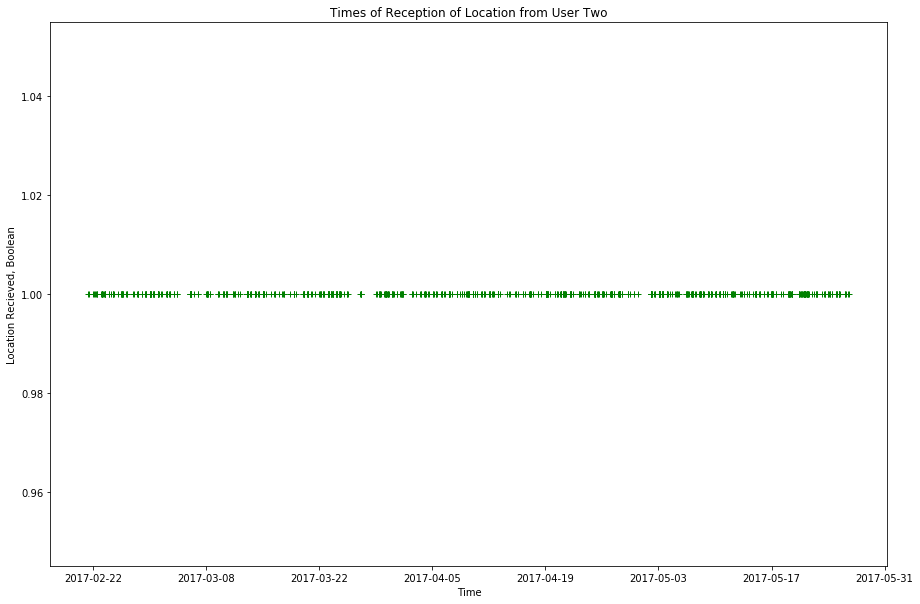

In [464]:
plt.figure(figsize=(15,10))
pointdf2 = (ID2sorted['long'] != 0)

pointdf2 = pointdf2.loc['2017-2-21':'2017-6-1'] # omit the early point data to get uninteruppted data
pointdf2 = pointdf2[pointdf2.values != 0]

# times not one will be NANs - convert to zero
#pointdf = pointdf.fillna(0)

plt.plot(pointdf2.index, pointdf2, 'g+')

np.shape(pointdf2)
#pointdf2[0:50]
##np.shape(ID2sorted)
#plt.plot(ID2sorted['long'])
plt.xlabel('Time')
plt.ylabel('Location Recieved, Boolean')
plt.title('Times of Reception of Location from User Two')

In [465]:
delta2 = pd.DataFrame()
delta2['tvalue'] = pointdf2.index
delta2.head()

,tvalue
0,2017-02-21 11:13:35+00:00
1,2017-02-21 12:40:47+00:00
2,2017-02-22 01:27:53+00:00
3,2017-02-22 03:25:46+00:00
4,2017-02-22 05:15:29+00:00


In [466]:
delta2['tvalue'] = delta2['tvalue'] - delta2['tvalue'].shift()
delta2.head(10)

,tvalue
0,NaT
1,01:27:12
2,12:47:06
3,01:57:53
4,01:49:43
5,05:37:42
6,00:12:07
7,01:39:48
8,12:02:41
9,01:18:54


Text(0.5,1,'Time Interval between Locations Recieved against Time for User Two')

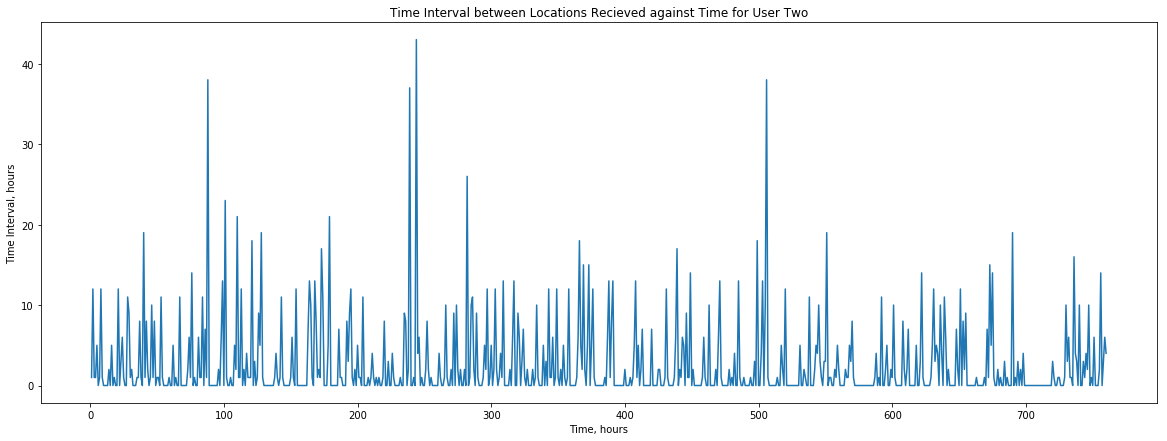

In [467]:
fig = plt.figure(figsize=(20,7))
np.shape(delta2)

delarray2 = delta2['tvalue'].astype('timedelta64[s]')

delarrayplot2 = delta2['tvalue'].astype('timedelta64[h]')

delarray2 = delarray2.dropna() 
delarrayplot2 = delarrayplot2.dropna()

plt.plot(delarrayplot2)

plt.xlabel('Time, hours')
plt.ylabel('Time Interval, hours')
plt.title('Time Interval between Locations Recieved against Time for User Two')

In [468]:
delarray2.head(10)

1      5232.0
2     46026.0
3      7073.0
4      6583.0
5     20262.0
6       727.0
7      5988.0
8     43361.0
9      4734.0
10      759.0
Name: tvalue, dtype: float64

Text(0.5,1,'Distribution of Times between Location Recieves for User Two')

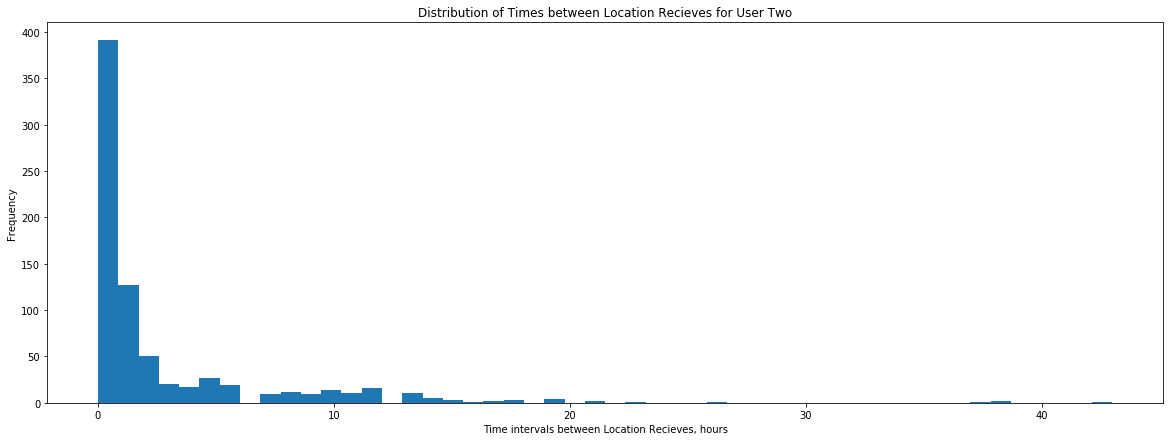

In [469]:
fig = plt.figure(figsize=(20,7))
delarrayplot2.plot.hist(bins=50)
plt.xlabel('Time intervals between Location Recieves, hours')
plt.title('Distribution of Times between Location Recieves for User Two')

Text(0.5,1,'Exponential Q-Q Plot')

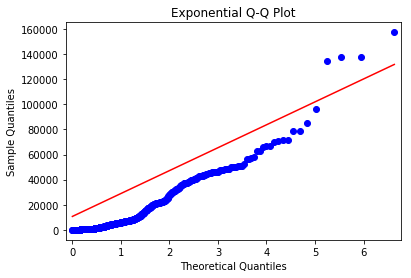

In [470]:


fig = sm.qqplot(delarray2, stats.expon, line='s')
plt.title('Exponential Q-Q Plot')

The Q-Q plot for user two does not exhibit the same behaviour as the the one for user one. Apart from more outliers it does not deviate from the ideal as much as it did for user one. It has hard to say for certain how many hidden components are present in the data but there seems to be only one.

As an illustrative example I plot a Q-Q plot of the user data against a Gaussian distribution. It can be seen how greatly the data deviates from the normal distribution.

Text(0.5,1,'Gaussian Q-Q Plot')

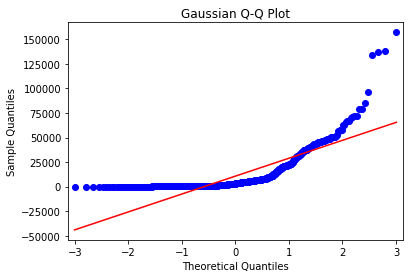

In [471]:
fig = sm.qqplot(delarray2, line='s')
plt.title('Gaussian Q-Q Plot')

Text(0.5,1,'Counts of Locations Received per 3 Days Against Time, for User Two')

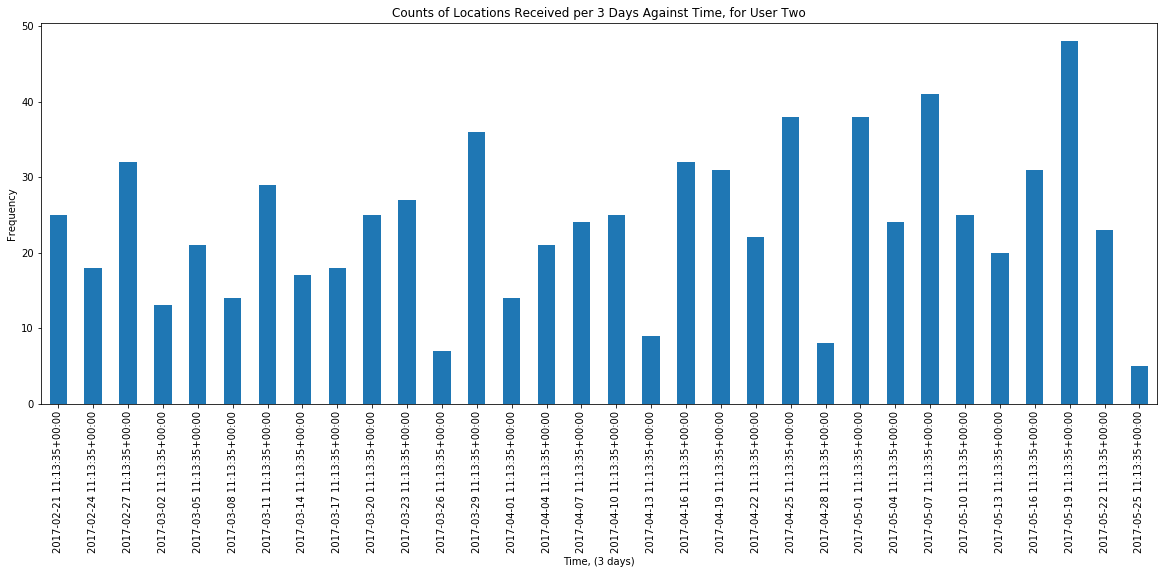

In [472]:
plt.figure(figsize=(20,7))

countdf2 = pointdf2.groupby(pd.TimeGrouper(freq='3D')).agg('sum')

countdf2.plot(kind='bar')
plt.xlabel('Time, (3 days)')
plt.ylabel('Frequency')
plt.title('Counts of Locations Received per 3 Days Against Time, for User Two')

In [473]:
from skbayes.hidden_markov_models import VBPoissonHMM

count2 = countdf2.values


count2 = count2.reshape(-1, 1)
model2 = VBPoissonHMM(n_hidden=2, n_init = 2, tol = 1e-3).fit(count2)
hidden_states2 = model.predict(count2)
#plt.figure(figsize=(20,7))
#plt.plot(hidden_states2)
#plt.xlabel('Time')
#plt.ylabel('State')
#plt.title('States Found by Poisson Hidden Markov Model versus Time for User Two')

C:\Users\jamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [474]:
hidden_states2 = hidden_states2[:, None]
np.shape(hidden_states2)

(32, 1)

In [475]:
hiddenup2 = np.kron(hidden_states2, np.ones((3,1), hidden_states2.dtype))
np.shape(hiddenup2)
np.squeeze(hiddenup2)
np.shape(hiddenup2)

(96, 1)

Text(0.5,1,'States Found by Poisson Hidden Markov Model versus Time for User Two')

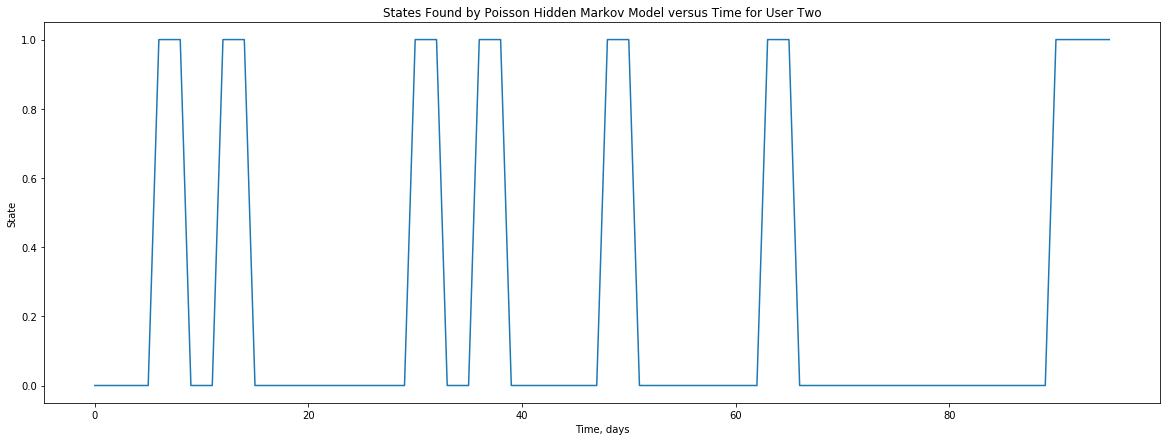

In [476]:
plt.figure(figsize=(20,7))

plt.plot(hiddenup2)
plt.xlabel('Time, days')
plt.ylabel('State')
plt.title('States Found by Poisson Hidden Markov Model versus Time for User Two')

### Discussion on User Two

## Profile of User Three

Finally we investigate the location data for user three.

In [477]:
ID3 = data[ data['ID'] == '283FCF1B13BC4D9C947AD983621D1EB1']
ID3.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.604250,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.606490,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:19:47+00:00,-6.906105,107.603905,1414,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.605510,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.609440,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [478]:
ID3.describe()

,lat,long,error
count,885.000000,885.000000,885.000000
mean,-6.884420,107.597643,253.307345
std,0.123214,0.389139,428.099124
min,-8.738699,106.153940,5.000000
25%,-6.895988,107.604904,65.000000
50%,-6.893502,107.606300,165.000000
75%,-6.892060,107.607900,165.000000
max,-6.117221,115.181850,3000.000000


In [479]:
ID3[ID3['error'] > 300].count()

lat          93
long         93
error        93
time_zone    93
ID           93
dtype: int64

In [480]:
ID3 = ID3[ID3['error'] < 300]
ID3.describe()

,lat,long,error
count,792.000000,792.000000,792.000000
mean,-6.888392,107.600179,111.704545
std,0.093214,0.292789,58.599337
min,-8.714790,106.279410,5.000000
25%,-6.895576,107.605297,65.000000
50%,-6.893646,107.606465,138.000000
75%,-6.892176,107.607891,165.000000
max,-6.143725,115.173760,229.000000


In [481]:
lat3 = ID3['lat'].values
long3 = ID3['long'].values
error3 = ID3['error'].values
np.shape(lat3)

(792,)

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 106.27941 115.17376
latitude range -8.71479 -6.143725
size of data (792,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


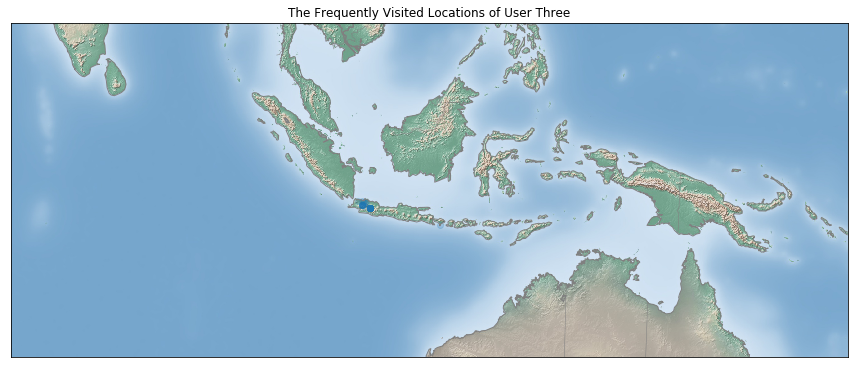

In [482]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('The Frequently Visited Locations of User Three')

print('longitude range', np.min(long3), np.max(long3))
print('latitude range', np.min(lat3), np.max(lat3))
print('size of data', np.shape(long3))
map.scatter(long3, lat3, latlon=True, alpha=0.2)

Text(0.5,1,'Time Evolution of Location Coordinates of User Three')

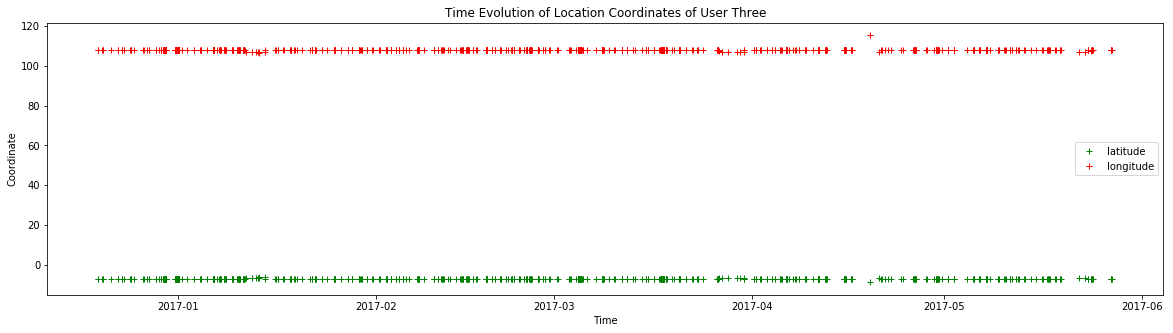

In [483]:
fig = plt.figure(figsize=[20,5])
plt.plot (ID3.index, lat3, 'g+', label = 'latitude')
plt.plot (ID3.index, long3, 'r+', label = 'longitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Location Coordinates of User Three')

Text(0,0.5,'latitude')

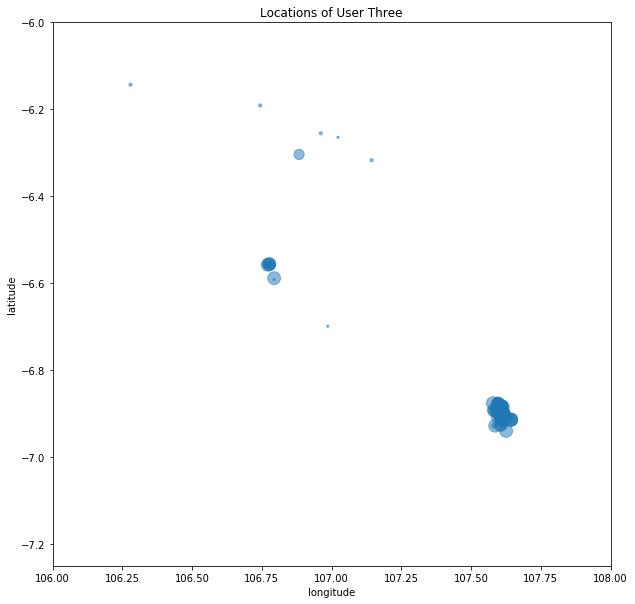

In [484]:

fig = plt.figure(figsize=(10,10))
plt.scatter(long3, lat3, s=error3, alpha = 0.5)
plt.ylim(-7.25,-6.00)
plt.xlim(106,108)
plt.title('Locations of User Three')
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('longitude')
plt.ylabel('latitude')

## Temporal Distribution for User Three

Finally, I repeat the above procedure for user three.

Time evolution of user location is less evident from this data so I plot one coordinate magnified.

Text(0.5,1,'Time Evolution of Latitude of User Three')

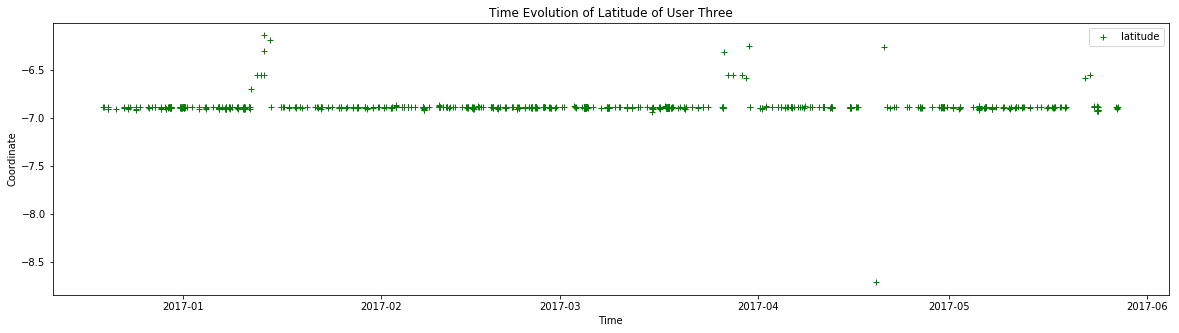

In [485]:
fig = plt.figure(figsize=[20,5])
plt.plot (ID3.index, lat3, 'g+', label = 'latitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Latitude of User Three')

In [486]:
ID3sorted = ID3

ID3sorted.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.60425,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.60649,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.60551,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.60944,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:58:18+00:00,-6.906175,107.60775,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


Text(0.5,1,'Times of Reception of Location from User Three')

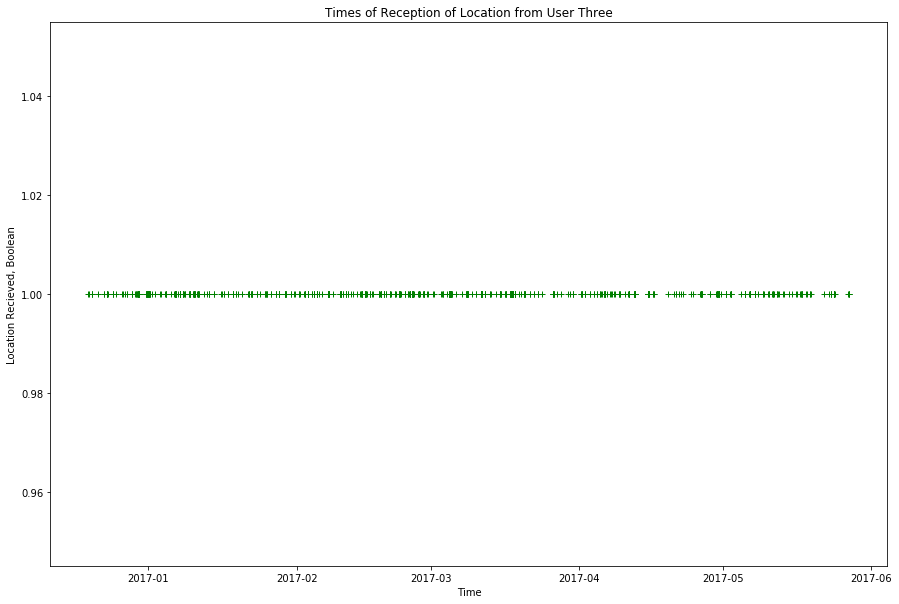

In [487]:
plt.figure(figsize=(15,10))
pointdf3 = (ID3sorted['long'] != 0)

#pointdf = pointdf.loc['2017-1':'2017-4']
pointdf3 = pointdf3[pointdf3.values != 0]

# times not one will be NANs - convert to zero
#pointdf = pointdf3.fillna(0)

plt.plot(pointdf3.index, pointdf3, 'g+')

np.shape(pointdf3)
pointdf3.head()
plt.xlabel('Time')
plt.ylabel('Location Recieved, Boolean')
plt.title('Times of Reception of Location from User Three')

In [488]:
delta3 = pd.DataFrame()
delta3['tvalue'] = pointdf3.index
delta3.head()

,tvalue
0,2016-12-19 11:55:12+00:00
1,2016-12-19 13:45:13+00:00
2,2016-12-20 04:56:59+00:00
3,2016-12-20 06:11:56+00:00
4,2016-12-20 06:58:18+00:00


In [489]:
delta3['tvalue'] = delta3['tvalue'] - delta3['tvalue'].shift()
delta3.head()

,tvalue
0,NaT
1,01:50:01
2,15:11:46
3,01:14:57
4,00:46:22


Text(0.5,1,'Time Interval between Locations Recieved against Time for User Three')

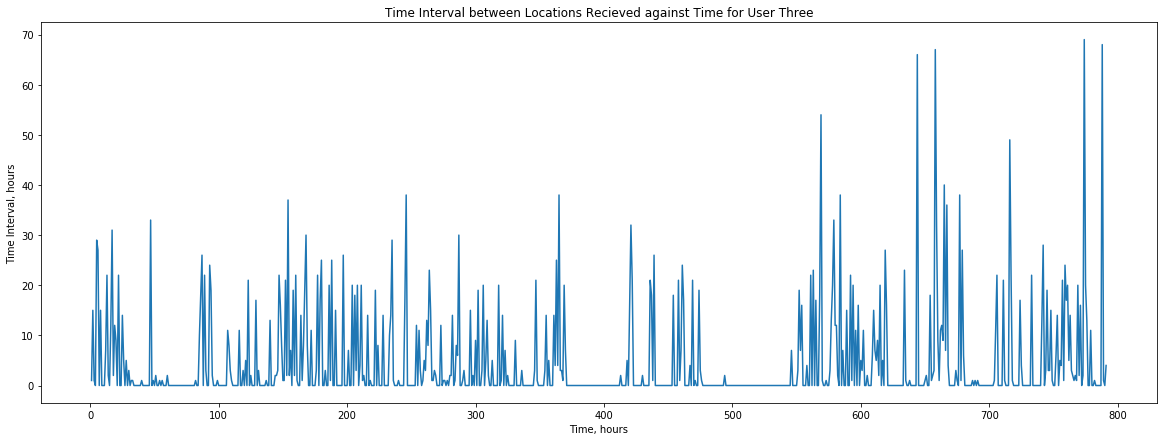

In [490]:
fig = plt.figure(figsize=(20,7))
np.shape(delta3)

delarray3 = delta3['tvalue'].astype('timedelta64[s]')

delarrayplot3 = delta3['tvalue'].astype('timedelta64[h]')

delarray3 = delarray3.dropna()
delarrayplot2 = delarrayplot3.dropna()

plt.plot(delarrayplot3)
plt.xlabel('Time, hours')
plt.ylabel('Time Interval, hours')
plt.title('Time Interval between Locations Recieved against Time for User Three')

Text(0.5,1,'Distribution of Times between Location Recieves for User Three')

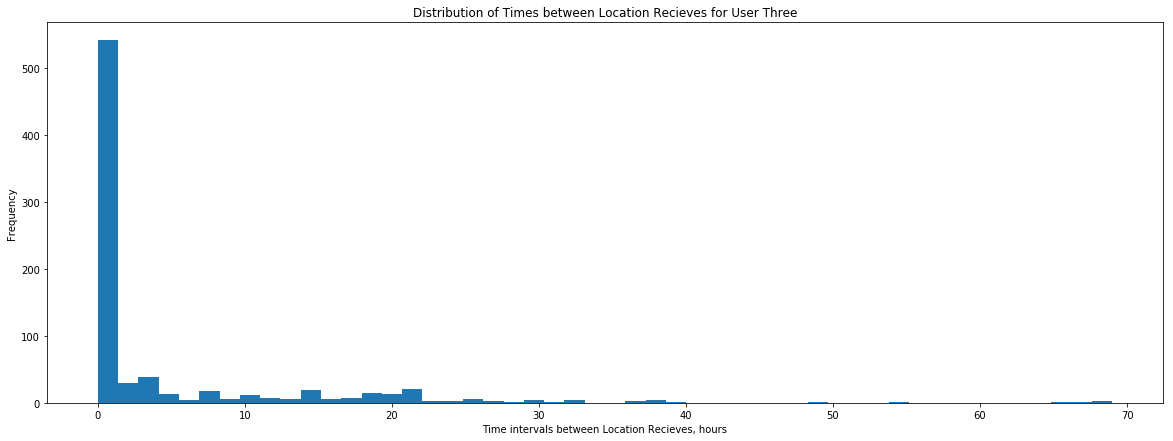

In [491]:
fig = plt.figure(figsize=(20,7))
delarrayplot3.plot.hist(bins=50)
plt.xlabel('Time intervals between Location Recieves, hours')
plt.title('Distribution of Times between Location Recieves for User Three')

In [492]:
delarray3.head()

1      6601.0
2     54706.0
3      4497.0
4      2782.0
5    105622.0
Name: tvalue, dtype: float64

Text(0.5,1,'Exponential Q-Q Plot')

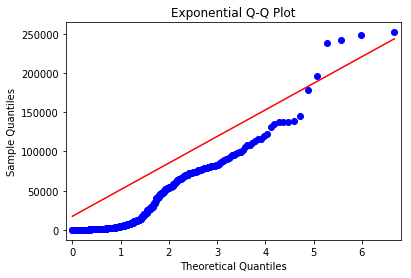

In [493]:
import statsmodels.api as sm
import scipy.stats as stats

fig = sm.qqplot(delarray3, stats.expon, line='s')
plt.title('Exponential Q-Q Plot')

As with user one this Q-Q plot suggests two hidden states. Though this data has more outliers than the data for user one.

Text(0.5,1,'Counts of Locations Received per 3 Days Against Time, for User Three')

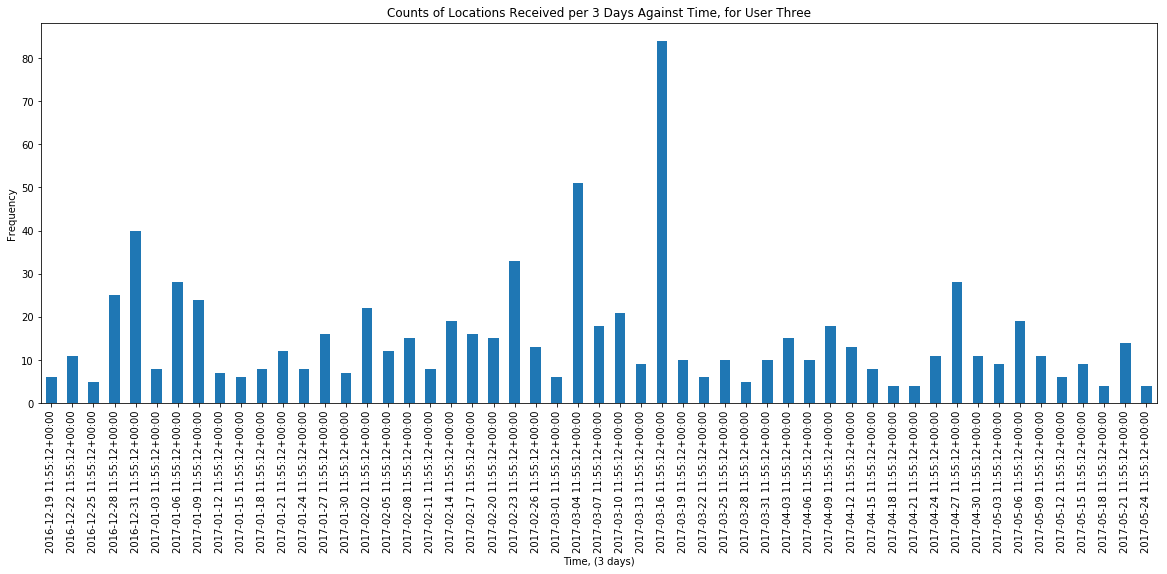

In [494]:
plt.figure(figsize=(20,7))

countdf3 = pointdf3.groupby(pd.TimeGrouper(freq='3D')).agg('sum')

countdf3.plot(kind='bar')
np.shape(countdf3)
plt.xlabel('Time, (3 days)')
plt.ylabel('Frequency')
plt.title('Counts of Locations Received per 3 Days Against Time, for User Three')

In [495]:
count3 = countdf3.values
count3 = count3.reshape(-1,1)
np.shape(count3)

(53, 1)

In [496]:
dates3 = np.linspace(0,count3.shape[0], count3.shape[0])
model3 = VBPoissonHMM(n_hidden=2, n_init = 2, tol = 1e-3).fit(count3)
hidden_states3 = model3.predict(count3)


#plt.figure(figsize=(20,7))
#plt.plot(hidden_states3)
#plt.xlabel('Time')
#plt.ylabel('State')
#plt.title('States Found by Poisson Hidden Markov Model versus Time for User Three')

In [497]:
hidden_states3 = hidden_states3[:, None]
np.shape(hidden_states3)

(53, 1)

In [498]:
hiddenup3 = np.kron(hidden_states3, np.ones((3,1), hidden_states3.dtype))
np.shape(hiddenup3)

(159, 1)

Text(0.5,1,'States Found by Poisson Hidden Markov Model versus Time for User Three')

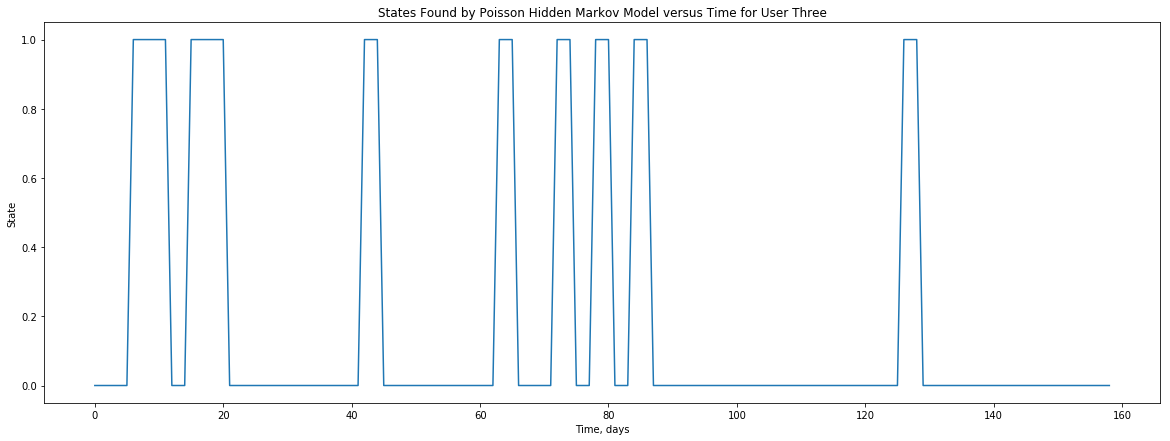

In [499]:
plt.figure(figsize=(20,7))

plt.plot(hiddenup3)
plt.xlabel('Time, days')
plt.ylabel('State')
plt.title('States Found by Poisson Hidden Markov Model versus Time for User Three')

### Discussion on User Three

# Conclusions

# Bibliography

1. Pattern Recognation and Machine Learning by Christopher Bishop.
2. Spatial-Temporal Clustering: a Survey by Kisilevich et al.
3. Python Data Science Handbook by Jake Vanderplas.
4. A Tutorial on Hidden Markov Models with Selected Applications in Speech Recognition by L. Rabiner. Proceedings of the IEEE. 1989. 
5. Stochastic Processes: Theory for Applications by Robert Gallager
